In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow_hub as hub

/opt/miniconda3/envs/ml-portfolio/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
# load the dataset
df = pd.read_csv('../data/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# clean the dataset and encode labels
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'Text'})
df['label_enc'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
# split data and convert to numpy array
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], 
    df['label_enc'],
    test_size=0.2,
    random_state=42)

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

In [5]:
avg_words_len = round(sum([len(i.split())
                           for i in df['Text']]) / len(df['Text']))
total_words_length = len(set(' '.join(df['Text']).split()))

print(f'Data Loaded.  Training samples: {len(X_train_np)}')
print(f'Average words per message: {avg_words_len}')
print(f'Approximate vocabulary size: {total_words_length}')

Data Loaded.  Training samples: 4457
Average words per message: 16
Approximate vocabulary size: 15686


In [6]:
# helper functions for training and evaluation
def compile_and_fit(model, epochs=5):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    history = model.fit(X_train_np, y_train_np, epochs=epochs, validation_data=(X_test_np, y_test_np))
    return history

def get_metrics(model, X, y):
    y_preds = np.round(model.predict(X))
    return {
    'accuracy': accuracy_score(y, y_preds),
    'precision': precision_score(y, y_preds),
    'recall': recall_score(y, y_preds),
    'f1-score': f1_score(y, y_preds)}

In [7]:
# TextVectorization layer to convert raw text into interger sequences
from tensorflow.keras.layers import TextVectorization
text_vec = TextVectorization(
    max_tokens=total_words_length,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len
)
text_vec.adapt(X_train_np)

In [8]:
# dense embedding model
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer, name='Dense_Model')
history_1 = compile_and_fit(model_1)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9096 - loss: 0.2717 - val_accuracy: 0.9596 - val_loss: 0.1414
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9780 - loss: 0.0855 - val_accuracy: 0.9740 - val_loss: 0.0794
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9897 - loss: 0.0391 - val_accuracy: 0.9794 - val_loss: 0.0686
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9951 - loss: 0.0248 - val_accuracy: 0.9776 - val_loss: 0.0682
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9966 - loss: 0.0160 - val_accuracy: 0.9776 - val_loss: 0.0669


In [9]:
# bidirectional LSTM model
input_layer = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(input_layer)
x = layers.Embedding(input_dim=total_words_length, output_dim=128)(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer, name='BiLSTM_Model')
history_2 = compile_and_fit(model_2)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9444 - loss: 0.1682 - val_accuracy: 0.9758 - val_loss: 0.0750
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9901 - loss: 0.0350 - val_accuracy: 0.9812 - val_loss: 0.0645
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9966 - loss: 0.0140 - val_accuracy: 0.9758 - val_loss: 0.0780
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9749 - val_loss: 0.0887
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9991 - loss: 0.0020 - val_accuracy: 0.9740 - val_loss: 0.1144


In [10]:
# transfer learning with universal sentence encoder
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
input_layer = layers.Input(shape=[], dtype=tf.string)
embedding = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)
x = layers.Dense(64, activation='relu')(embedding)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_3 = keras.Model(input_layer, output_layer, name='USE_Model')
history_3 = compile_and_fit(model_3)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9226 - loss: 0.2962 - val_accuracy: 0.9704 - val_loss: 0.1121
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9782 - loss: 0.0816 - val_accuracy: 0.9785 - val_loss: 0.0707
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9834 - loss: 0.0577 - val_accuracy: 0.9812 - val_loss: 0.0602
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9877 - loss: 0.0463 - val_accuracy: 0.9830 - val_loss: 0.0558
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9879 - loss: 0.0396 - val_accuracy: 0.9830 - val_loss: 0.0530


In [11]:
# collect perfomance metrics for all models
results = {
    'Dense Embedding': get_metrics(model_1, X_test_np, y_test_np), 
    'Bi-LSTM': get_metrics(model_2, X_test_np, y_test_np),
    'Transfer Learning (USE)': get_metrics(model_3, X_test_np, y_test_np)
}

results_df = pd.DataFrame(results).transpose()
print('Performance Table: ')
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Performance Table: 
                         accuracy  precision    recall  f1-score
Dense Embedding          0.977578   0.955882  0.872483  0.912281
Bi-LSTM                  0.973991   0.905405  0.899329  0.902357
Transfer Learning (USE)  0.982960   0.945205  0.926174  0.935593


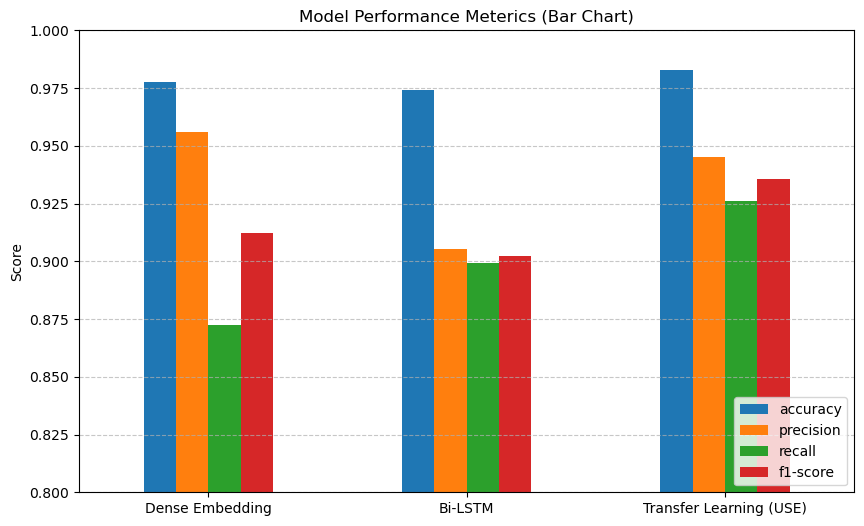

In [12]:
# visualize: bar
results_df.plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Meterics (Bar Chart)')
plt.ylabel('Score')
plt.ylim([0.8, 1.0])
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../results/figures/barCharts.png', dpi=300, bbox_inches='tight')

plt.show()

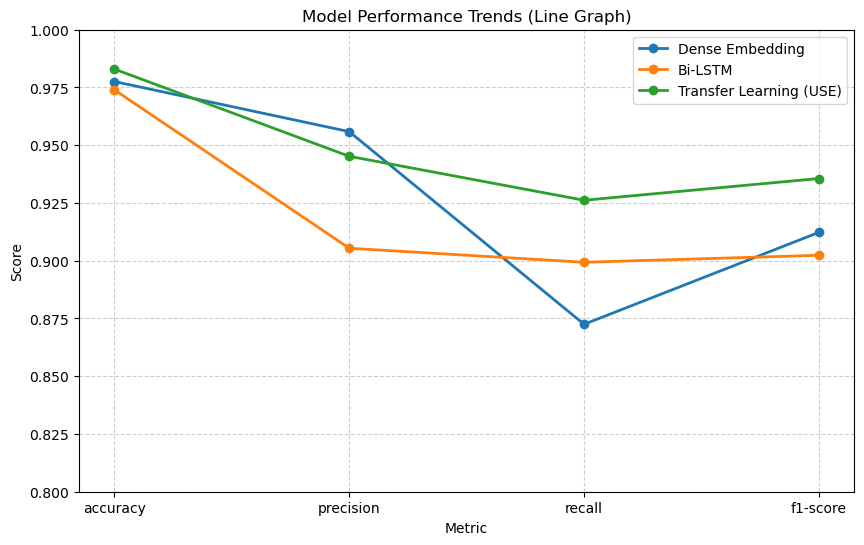

In [13]:
# visualize: line
plt.figure(figsize=(10, 6))
for model_name in results_df.index:
    plt.plot(
        results_df.columns,
        results_df.loc[model_name],
        marker='o',
        label=model_name,
        linewidth=2)

plt.title('Model Performance Trends (Line Graph)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim([0.8, 1.0])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.savefig('../results/figures/modelPerformance.png', dpi=300, bbox_inches='tight')

plt.show()